# ESG News Classification Using RoBERTa

## Objective
The goal of this notebook is to train a transformer-based model capable of automatically classifying news articles as ESG-related (Environmental, Social, or Governance) or not ESG-related.

This step is crucial to ensure that only relevant ESG content is used in the subsequent stages of the project.

## Approach
- We utilize a manually labeled dataset containing news articles classified as ESG or Non-ESG.
- A pre-trained RoBERTa model (`roberta-base`) is fine-tuned on this dataset to perform binary classification.
- Texts are tokenized using the official RoBERTa tokenizer.
- The model is trained and validated, and performance is monitored across epochs.
- After training, the model and tokenizer are saved for future inference on new, unlabeled news articles.

RoBERTa (Robustly Optimized BERT Pretraining Approach) has demonstrated superior performance in a variety of natural language understanding tasks. Its ability to capture contextual information makes it ideal for nuanced classifications such as ESG news identification.

In [ ]:
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import joblib
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/sample_esg_or_not.csv'
df_trainning = pd.read_csv(path)
df_trainning

,id,Publication Date,title,content,source,sentiment_body,sentiment_body_score,company,sector,url,ticker,description,input_text,predicted_esg
0,NaN,2021-04-26T19:00:00Z,Recommended strategies and best practices for ...,Posted by Wally Brill and Jessica Dene Earley-...,Googleblog.com,NaN,NaN,google,NaN,https://developers.googleblog.com/2021/04/Acti...,GOOGL,Here are three key things to keep in mind when...,Recommended strategies and best practices for ...,False
1,333.0,2023-07-10 19:46:51+00:00,The other reason banks aren't making cataclysm...,For all the talk about job cuts in investment ...,EFinancialCareers Italy,negative,0.61,morgan stanley,Finance,NaN,MS,NaN,The other reason banks aren't making cataclysm...,False
2,NaN,2022-06-03T18:00:00Z,"Amazon, Governor Baker Officially Open New Tec...",The latest Amazon office to open in the Seapor...,Yahoo Entertainment,NaN,NaN,amazon,NaN,https://finance.yahoo.com/news/amazon-governor...,AMZN,"BOSTON, June 03, 2022--Today Amazon, along wit...","Amazon, Governor Baker Officially Open New Tec...",True
3,NaN,2021-09-23T10:00:41Z,Using an Amazon Registry So Friends and Family...,"If you buy something through our links, we may...",Small Business Trends,NaN,NaN,amazon,NaN,https://smallbiztrends.com/2021/09/amazon-regi...,AMZN,Using an Amazon registry so friends and family...,Using an Amazon Registry So Friends and Family...,False
4,11800.0,2023-09-08 14:00:53+00:00,Unraveling the European Agricultural Policy Su...,Open Access Article by Yannis E. Doukas Yan...,International Journal of Molecular Sciences,NaN,NaN,google,Technology,https://www.mdpi.com/2073-445X/12/9/1749,GOOGL,NaN,Unraveling the European Agricultural Policy Su...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,NaN,2021-06-01T16:12:07Z,Coinbase Card Now Accepted By Google And Apple...,Coinbase announced integration with Google and...,Yahoo Entertainment,NaN,NaN,apple,NaN,https://finance.yahoo.com/news/coinbase-card-n...,AAPL,Coinbase tests the roll-out of its crypto card...,Coinbase Card Now Accepted By Google And Apple...,False
5996,NaN,2021-10-08T17:43:02Z,Twitch got e-vandalized overnight with photos ...,(Bigstock Photo).\r\nIf you were using the web...,GeekWire,NaN,NaN,amazon,NaN,https://www.geekwire.com/2021/twitch-got-e-van...,AMZN,If you were using the web version of Twitch ea...,Twitch got e-vandalized overnight with photos ...,True
5997,NaN,2020-12-09T21:30:21Z,"Pixel 2 XL is the Best Pixel of All Time, Right?",We said “Goodbye!” to continued software suppo...,Droid Life,NaN,NaN,google,NaN,https://www.droid-life.com/2020/12/09/pixel-2-...,GOOGL,We said “Goodbye!” to continued software suppo...,"Pixel 2 XL is the Best Pixel of All Time, Righ...",False
5998,NaN,2020-06-25T10:42:56Z,Huawei P40 Pro series gets EMUI 10.1.0.140 wit...,Huawei has been striving to give several reaso...,XDA Developers,NaN,NaN,google,NaN,https://www.xda-developers.com/?p=310535,GOOGL,Huawei has been striving to give several reaso...,Huawei P40 Pro series gets EMUI 10.1.0.140 wit...,False


In [ ]:
df_trainning['predicted_esg'] = df_trainning['predicted_esg'].astype(int)

In [ ]:
df_trainning.rename(columns={
    'input_text': 'text',
    'predicted_esg': 'Valid ESG'
}, inplace=True)

### Addressing Class Imbalance
The dataset is imbalanced, with significantly more non-ESG news ('0') than ESG-related news ('1').  
To prevent the model from being biased towards the majority class, we apply **undersampling** to the '0' class.  
We randomly select 2,000 samples from the '0' class and combine them with all available '1' class samples.  
This ensures a more balanced and fair training process.

In [ ]:
df_0 = df_trainning[df_trainning['Valid ESG'] == 0]
df_1 = df_trainning[df_trainning['Valid ESG'] == 1]
df_0_downsampled = resample(df_0,
                            replace=False,
                            n_samples=2000,
                            random_state=42)
df_balanced = pd.concat([df_0_downsampled, df_1], ignore_index=True)

In [ ]:
df_balanced['Valid ESG'].value_counts()

,count
Valid ESG,
1,2329
0,2000


### Tokenizer Initialization and Label Renaming

We initialize the **RoBERTa tokenizer** from the Huggingface library, which will be used to encode our text data into model-compatible tokens.
We also rename the label column to "label" for consistency with PyTorch and Huggingface standards.

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
df_balanced = df_balanced.rename(columns={'Valid ESG': 'label'})

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
df_balanced = df_balanced.dropna(subset=['text'])

### Hyperparameter Configuration

We define the main hyperparameters for fine-tuning the RoBERTa model:

- **MAX_LEN = 256**:  
  The maximum sequence length was set to 256 tokens to balance information retention and computational efficiency. This value captures the core content of most news articles while ensuring faster training and reducing overfitting risk.

- **TRAIN_BATCH_SIZE = 32** and **VALID_BATCH_SIZE = 32**:  
  A batch size of 32 is a commonly used default that fits comfortably in GPU memory without causing memory overflow. It also ensures stable gradient updates.

- **EPOCHS = 10**:  
  Given the balanced size of the training dataset after resampling, 10 epochs provide enough iterations for the model to learn effectively without overfitting.

- **LEARNING_RATE = 1e-5**:  
  When fine-tuning large language models like RoBERTa, smaller learning rates (such as 1e-5) help achieve better convergence and avoid catastrophic forgetting of the pretrained knowledge.

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05

### Custom Dataset Class

We define a `CustomDataset` class to handle text preprocessing before feeding the samples into the RoBERTa model:

- **Text Normalization**:  
  Each text is first cleaned by removing excessive whitespace.

- **Tokenization**:  
  We use `encode_plus` from the HuggingFace tokenizer to:
  - Add special tokens required by RoBERTa.
  - Pad or truncate sequences to a fixed maximum length (MAX_LEN).
  - Generate an `attention_mask` to distinguish real tokens from padding.

- **Returning inputs**:  
  Each batch returned contains:
  - `input_ids`: Tokenized numerical representations of the text.
  - `attention_mask`: A binary mask indicating real tokens.
  - `targets`: The corresponding label for supervised learning.

This ensures compatibility with PyTorch's `DataLoader` and enables efficient batch processing during training.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'targets': torch.tensor(self.labels[index], dtype=torch.long)
        }

In [ ]:
df_balanced.reset_index(drop=True, inplace=True)

### Dataset Splitting

We split the balanced dataset into three subsets:

- **Training Set (80%)**: Used to optimize the model's parameters.
- **Validation Set (10%)**: Used for model selection and hyperparameter tuning.
- **Test Set (10%)**: Used to evaluate final model performance.

We use stratified sampling (`stratify=df_balanced['label']`) to preserve the original class distribution across all subsets, which is essential for maintaining balanced learning in classification tasks.

In [ ]:
train_df, temp_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

Train: 3463 samples
Validation: 433 samples
Test: 433 samples


In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN)

### DataLoader Creation

To optimize the model training and evaluation processes, we create three DataLoaders: one for training, one for validation, and one for testing.

A **DataLoader** in PyTorch serves two key purposes:
- It allows loading data in **mini-batches**, making training faster and more memory-efficient compared to loading the entire dataset at once.
- It provides options for **shuffling** the data during training to help the model generalize better.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### RoBERTa Model Architecture for ESG News Classification

We now define the architecture for fine-tuning a RoBERTa-based model for binary classification (ESG-related news vs non-ESG news).

**Model Components:**
- **Pre-trained RoBERTa Encoder**: We load `roberta-base` from Huggingface Transformers. This encoder transforms the input text into a rich, contextualized embedding of size 768.
- **Dropout Layer**: A dropout with a rate of 0.3 is applied to the pooled output to prevent overfitting, by randomly deactivating neurons during training.
- **Fully Connected Layer**: A final dense layer maps the 768-dimensional RoBERTa output to a 2-class output (0 = Non-ESG, 1 = ESG).

**Forward pass logic:**
- The input `input_ids` and `attention_mask` are fed into RoBERTa.
- We use the **[CLS] pooled output** (i.e., a condensed vector summarizing the entire input sequence).
- Dropout is applied to regularize the model.
- Finally, a Linear Layer produces the logits for the two classes.

**Justification of design choices:**
- Using only the `pooler_output` simplifies the architecture and focuses the model on global understanding rather than token-level outputs.
- Dropout at 30% is a common practice to balance regularization and learning capacity.
- A simple fully connected head ensures the model remains lightweight and reduces the risk of overfitting on a small or medium-sized training dataset.

This setup allows leveraging the power of RoBERTa while adapting the model specifically to our ESG classification task.

In [ ]:
class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.out = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = self.dropout(output.pooler_output)
        return self.out(pooled_output)
model = RoBERTaClass().to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Loss Function and Optimizer Configuration

We define the loss function and optimizer for training the RoBERTa-based model:

- **Loss Function: CrossEntropyLoss**
  - Suitable for multi-class (including binary) classification tasks.
  - Internally applies `LogSoftmax` followed by `Negative Log Likelihood`.
  - Since our task is binary (0 = Non-ESG, 1 = ESG), CrossEntropyLoss is appropriate.

- **Optimizer: AdamW**
  - A variant of the Adam optimizer specifically designed to work better with Transformer architectures.
  - Incorporates correct weight decay (W) handling, which improves generalization in pre-trained models.
  - We use a relatively low learning rate (`1e-5`) because we are fine-tuning a powerful pre-trained model, and large learning rates could cause catastrophic forgetting.

These choices ensure stable and effective fine-tuning of the RoBERTa model for the ESG classification task.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attn_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    train_accuracy = train_correct / train_total
    train_loss /= len(train_loader)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids, attn_mask)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            valid_total += targets.size(0)
            valid_correct += (predicted == targets).sum().item()

    valid_accuracy = valid_correct / valid_total
    valid_loss /= len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch {epoch + 1}/{EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {valid_loss:.4f}, Val Acc: {valid_accuracy:.4f}')

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.\n")
            break

model.load_state_dict(torch.load('best_model.pt'))

Epoch 1/10, Train Loss: 0.4900, Train Acc: 0.7346, Val Loss: 0.3309, Val Acc: 0.8476
Epoch 2/10, Train Loss: 0.2619, Train Acc: 0.8908, Val Loss: 0.3018, Val Acc: 0.8614
Epoch 3/10, Train Loss: 0.1809, Train Acc: 0.9264, Val Loss: 0.3871, Val Acc: 0.8614
Epoch 4/10, Train Loss: 0.1051, Train Acc: 0.9619, Val Loss: 0.3742, Val Acc: 0.8568
Epoch 5/10, Train Loss: 0.0808, Train Acc: 0.9729, Val Loss: 0.4182, Val Acc: 0.8591
Early stopping triggered after 5 epochs.



<All keys matched successfully>

In [ ]:
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids, attn_mask)
        loss = criterion(outputs, targets)

        _, predicted = torch.max(outputs, 1)
        test_loss += loss.item()
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_accuracy = test_correct / test_total
test_loss /= len(test_loader)

print(f" Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

 Test Loss: 0.2534, Test Accuracy: 0.8915


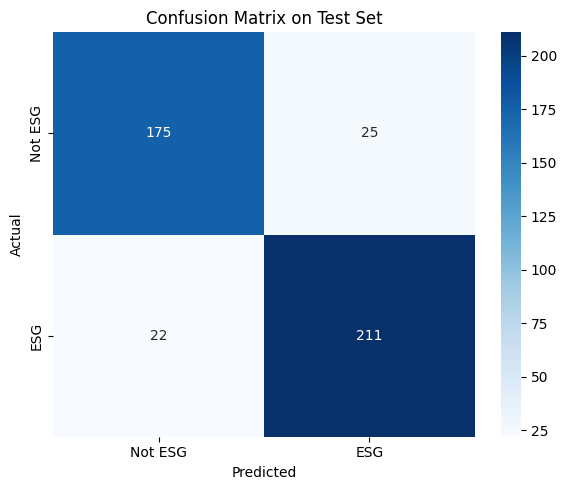

Classification Report on Test Set:
              precision    recall  f1-score   support

     Not ESG       0.89      0.88      0.88       200
         ESG       0.89      0.91      0.90       233

    accuracy                           0.89       433
   macro avg       0.89      0.89      0.89       433
weighted avg       0.89      0.89      0.89       433



In [ ]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not ESG", "ESG"], yticklabels=["Not ESG", "ESG"])
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("Classification Report on Test Set:")
print(classification_report(all_targets, all_preds, target_names=["Not ESG", "ESG"]))

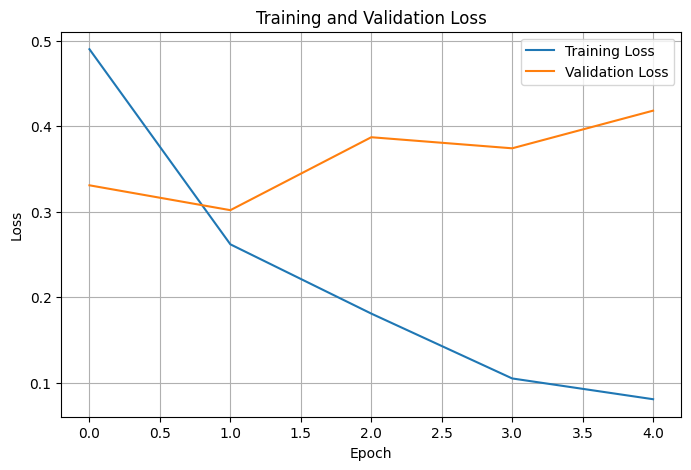

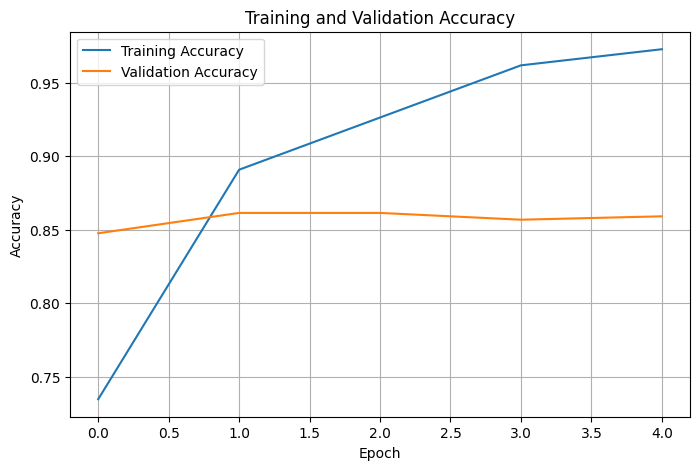

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/esg_model_weights.pt")